In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Read Data

In [2]:
feature_descriptions = pd.read_csv("feature_descriptions.csv")
feature_value_descriptions = pd.read_csv("feature_value_descriptions.csv")
train_hh_features = pd.read_csv("train_hh_features.csv")
train_hh_gt = pd.read_csv("train_hh_gt.csv")
train_rates_gt = pd.read_csv("train_rates_gt.csv")
test_hh_features = pd.read_csv("test_hh_features.csv")

## Features

In [3]:
feature_descriptions

,Variable name,Storage type,Variable label
0,sample,str8,Data Type
1,hhid,int,Household unique identifier
2,com,byte,Identifier of household member
3,weight,int,Household sampling weight
4,strata,byte,Stratification variable
...,...,...,...
103,_pline75,float,Poverty line: 75th percentile of welfare distr...
104,_pline80,float,Poverty line: 80th percentile of welfare distr...
105,_pline85,float,Poverty line: 85th percentile of welfare distr...
106,_pline90,float,Poverty line: 90th percentile of welfare distr...


In [4]:
feature_value_descriptions

,Variable name,Variable label,Value,Value label
0,any_nonagric,Any household member working in non-agricultur...,0,No
1,any_nonagric,Any household member working in non-agricultur...,1,Yes
2,consumed100,Breads,0,No
3,consumed100,Breads,1,Yes
4,consumed1000,Poultry offal,0,No
...,...,...,...,...
174,water_source,Sources of drinking water,10,Unprotected dug well
175,water_source,Sources of drinking water,11,Cart with small tank/drum
176,water_source,Sources of drinking water,12,Tanker-truck
177,water_source,Sources of drinking water,13,Surface water


### Data Preprocessing & Feature Engineering:

**Cleaning**: Handled missing values in sector and dwelling type logically; mapped categorical/binary education and infrastructure features to ordinal/numerical scales.

**Feature Engineering**: Add the following features:

* Dependency Ratio: Ratio of non-working age members to household size.
* Amenities Index: Aggregated access to water, electricity, and sanitation.
* Diet Diversity Score: Sum of food categories consumed as a proxy for economic status.
* Target Transformation: Applied log1p to consumption to normalize the skewed distribution.

In [5]:
import numpy as np
import pandas as pd


def preprocess_common(df, is_train=True):
    feat_df = df.copy()
    if is_train:
        feat_df = feat_df.dropna(subset=["sector1d", "employed"], how="all")
    # Data Cleaning & Filling
    feat_df["sector1d"] = feat_df["sector1d"].fillna("Unemployed")

    # Logical fill for dwelling type
    mask = (
        (feat_df["dweltyp"].isna())
        & (feat_df["water"] == "Access")
        & (feat_df["elect"] == "Access")
    )
    feat_df.loc[mask, "dweltyp"] = "Other"

    # Calculate children/elder ratio
    feat_df["dependency_ratio"] = (
        feat_df["num_children18"] + feat_df["num_elderly"]
    ) / feat_df["hsize"]
    infra_cols = ["elect", "water", "toilet", "sewer", "owner"]
    # Mapping strings to numbers for the index
    for col in infra_cols:
        if feat_df[col].dtype == object:
            feat_df[col] = (
                feat_df[col]
                .replace({"No access": 0, "Access": 1, "Not owner": 0, "Owner": 1})
                .astype(float)
            )
    feat_df["amenities_index"] = feat_df[infra_cols].sum(axis=1)

    # Dietary Diversity
    food_cols = [c for c in feat_df.columns if "consumed" in c]
    for col in food_cols:
        if feat_df[col].dtype == object:
            feat_df[col] = feat_df[col].replace({"No": 0, "Yes": 1}).astype(float)
    feat_df["diet_diversity"] = feat_df[food_cols].sum(axis=1)

    # Binary & Ordinal Encoding
    encoding_map = {
        "any_nonagric": {"No": 0, "Yes": 1},
        "employed": {"Employed": 1, "Not employed": 0},
        "male": {"Female": 0, "Male": 1},
        "urban": {"Rural": 0, "Urban": 1},
        "educ_max": {
            "Never attended": 0,
            "Incomplete Primary Education": 1,
            "Complete Primary Education": 2,
            "Incomplete Secondary Education": 3,
            "Complete Secondary Education": 4,
            "Incomplete Tertiary Education": 5,
            "Complete Tertiary Education": 6,
        },
    }
    for col, mapping in encoding_map.items():
        feat_df[col] = feat_df[col].replace(mapping).astype(float)

    # One-Hot Encoding
    nominal = ["water_source", "sanitation_source", "dweltyp", "sector1d"]
    feat_df = pd.get_dummies(feat_df, columns=nominal, prefix=nominal, dtype=float)

    # Remove com column
    if "com" in feat_df.columns:
        feat_df.drop(columns=["com"], inplace=True)

    return feat_df


def preprocess_train_only(df, gt_df, rates_gt_df):
    # Merge Ground Truth
    train_df = df.merge(
        gt_df[["survey_id", "hhid", "cons_ppp17"]], on=["survey_id", "hhid"], how="left"
    )

    # Drop Rows with NaNs
    cons_cols = [c for c in train_df.columns if "consumed" in c]
    train_df = train_df.dropna(
        subset=cons_cols
        + [
            "share_secondary",
            "educ_max",
            "utl_exp_ppp17",
            "employed",
        ]
    )

    # Add poverty class to rows
    thresholds_float = [
        3.17,
        3.94,
        4.60,
        5.26,
        5.88,
        6.47,
        7.06,
        7.70,
        8.40,
        9.13,
        9.87,
        10.70,
        11.62,
        12.69,
        14.03,
        15.64,
        17.76,
        20.99,
        27.37,
    ]

    rate_cols = [
        f"pct_hh_below_{t:.2f}"
        if f"pct_hh_below_{t:.2f}" in rates_gt_df.columns
        else f"pct_hh_below_{str(t).rstrip('0').rstrip('.')}"
        for t in thresholds_float
    ]
    # Adjusting for potential string formatting differences in column names
    actual_cols = [c for c in rates_gt_df.columns if "pct_hh_below" in c]

    rates_lookup = rates_gt_df.set_index("survey_id")[actual_cols].values
    survey_id_map = {sid: i for i, sid in enumerate(rates_gt_df["survey_id"])}

    indices = np.digitize(train_df["cons_ppp17"].values, thresholds_float, right=False)
    survey_indices = train_df["survey_id"].map(survey_id_map).values

    valid_mask = indices < len(actual_cols)
    poverty_values = np.ones(len(train_df))
    poverty_values[valid_mask] = rates_lookup[
        survey_indices[valid_mask], indices[valid_mask]
    ]

    train_df["poverty"] = poverty_values
    return train_df


# Process train and test sets
train_processed = preprocess_common(train_hh_features)
train_final = preprocess_train_only(train_processed, train_hh_gt, train_rates_gt)
test_final = preprocess_common(test_hh_features)

C:\Users\zikopis\AppData\Local\Temp\ipykernel_11552\3560695808.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"No access": 0, "Access": 1, "Not owner": 0, "Owner": 1})
C:\Users\zikopis\AppData\Local\Temp\ipykernel_11552\3560695808.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"No access": 0, "Access": 1, "Not owner": 0, "Owner": 1})
C:\Users\zikopis\AppData\Local\Temp\ipykernel_11552\3560695808.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future ver

## Train Dataset

In [6]:
train_final.head()

,hhid,weight,strata,utl_exp_ppp17,male,hsize,num_children5,num_children10,num_children18,age,...,sector1d_Manufacturing,sector1d_Mining and quarrying,"sector1d_Other community, social and personal service activities",sector1d_Public administration and defence,"sector1d_Real estate, renting and business activities","sector1d_Transport, storage and communications",sector1d_Unemployed,sector1d_Wholesale and retail trade,cons_ppp17,poverty
0,100001,75,4,594.80627,0.0,1,0,0,0,75,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,25.258402,0.954239
1,100002,150,4,1676.27230,0.0,2,0,0,0,61,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16.996706,0.865121
2,100003,375,4,506.93719,1.0,5,0,0,2,49,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,13.671848,0.773303
3,100004,375,4,824.61786,1.0,5,0,0,1,58,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.189475,0.419816
4,100005,525,4,351.47644,1.0,7,1,0,0,57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.308855,0.721329


### Null Values

In [7]:
train_final.isna().sum().loc[lambda x: x > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [8]:
train_final.describe()

,hhid,weight,strata,utl_exp_ppp17,male,hsize,num_children5,num_children10,num_children18,age,...,sector1d_Manufacturing,sector1d_Mining and quarrying,"sector1d_Other community, social and personal service activities",sector1d_Public administration and defence,"sector1d_Real estate, renting and business activities","sector1d_Transport, storage and communications",sector1d_Unemployed,sector1d_Wholesale and retail trade,cons_ppp17,poverty
count,103968.000000,103968.000000,103968.000000,103968.000000,103968.000000,103968.000000,103968.000000,103968.000000,103968.000000,103968.000000,...,103968.000000,103968.000000,103968.000000,103968.000000,103968.000000,103968.000000,103968.000000,103968.000000,103968.000000,103968.000000
mean,222390.632146,926.046418,4.425265,510.059335,0.725791,3.611169,0.287781,0.338008,0.570599,52.596337,...,0.053401,0.016034,0.020362,0.039733,0.025123,0.063135,0.135157,0.110351,11.555851,0.521222
std,83245.967434,1120.891284,2.428180,437.192437,0.446117,1.926949,0.561506,0.598167,0.831210,15.726388,...,0.224833,0.125606,0.141236,0.195333,0.156500,0.243206,0.341893,0.313329,10.029063,0.299135
min,100001.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,15.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.359563,0.049803
25%,126039.750000,270.000000,2.000000,190.115800,0.000000,2.000000,0.000000,0.000000,0.000000,41.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.440904,0.250192
50%,219875.500000,582.000000,5.000000,411.917570,1.000000,3.000000,0.000000,0.000000,0.000000,52.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.774355,0.512931
75%,311316.250000,1128.000000,7.000000,722.440060,1.000000,5.000000,0.000000,1.000000,1.000000,64.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.220105,0.800111
max,337462.000000,23832.000000,8.000000,5880.471200,1.000000,21.000000,5.000000,6.000000,6.000000,98.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,236.115680,1.000000


### Weights
Plot weights feature to see how it aligns with number of people in household and per-capita consumption.

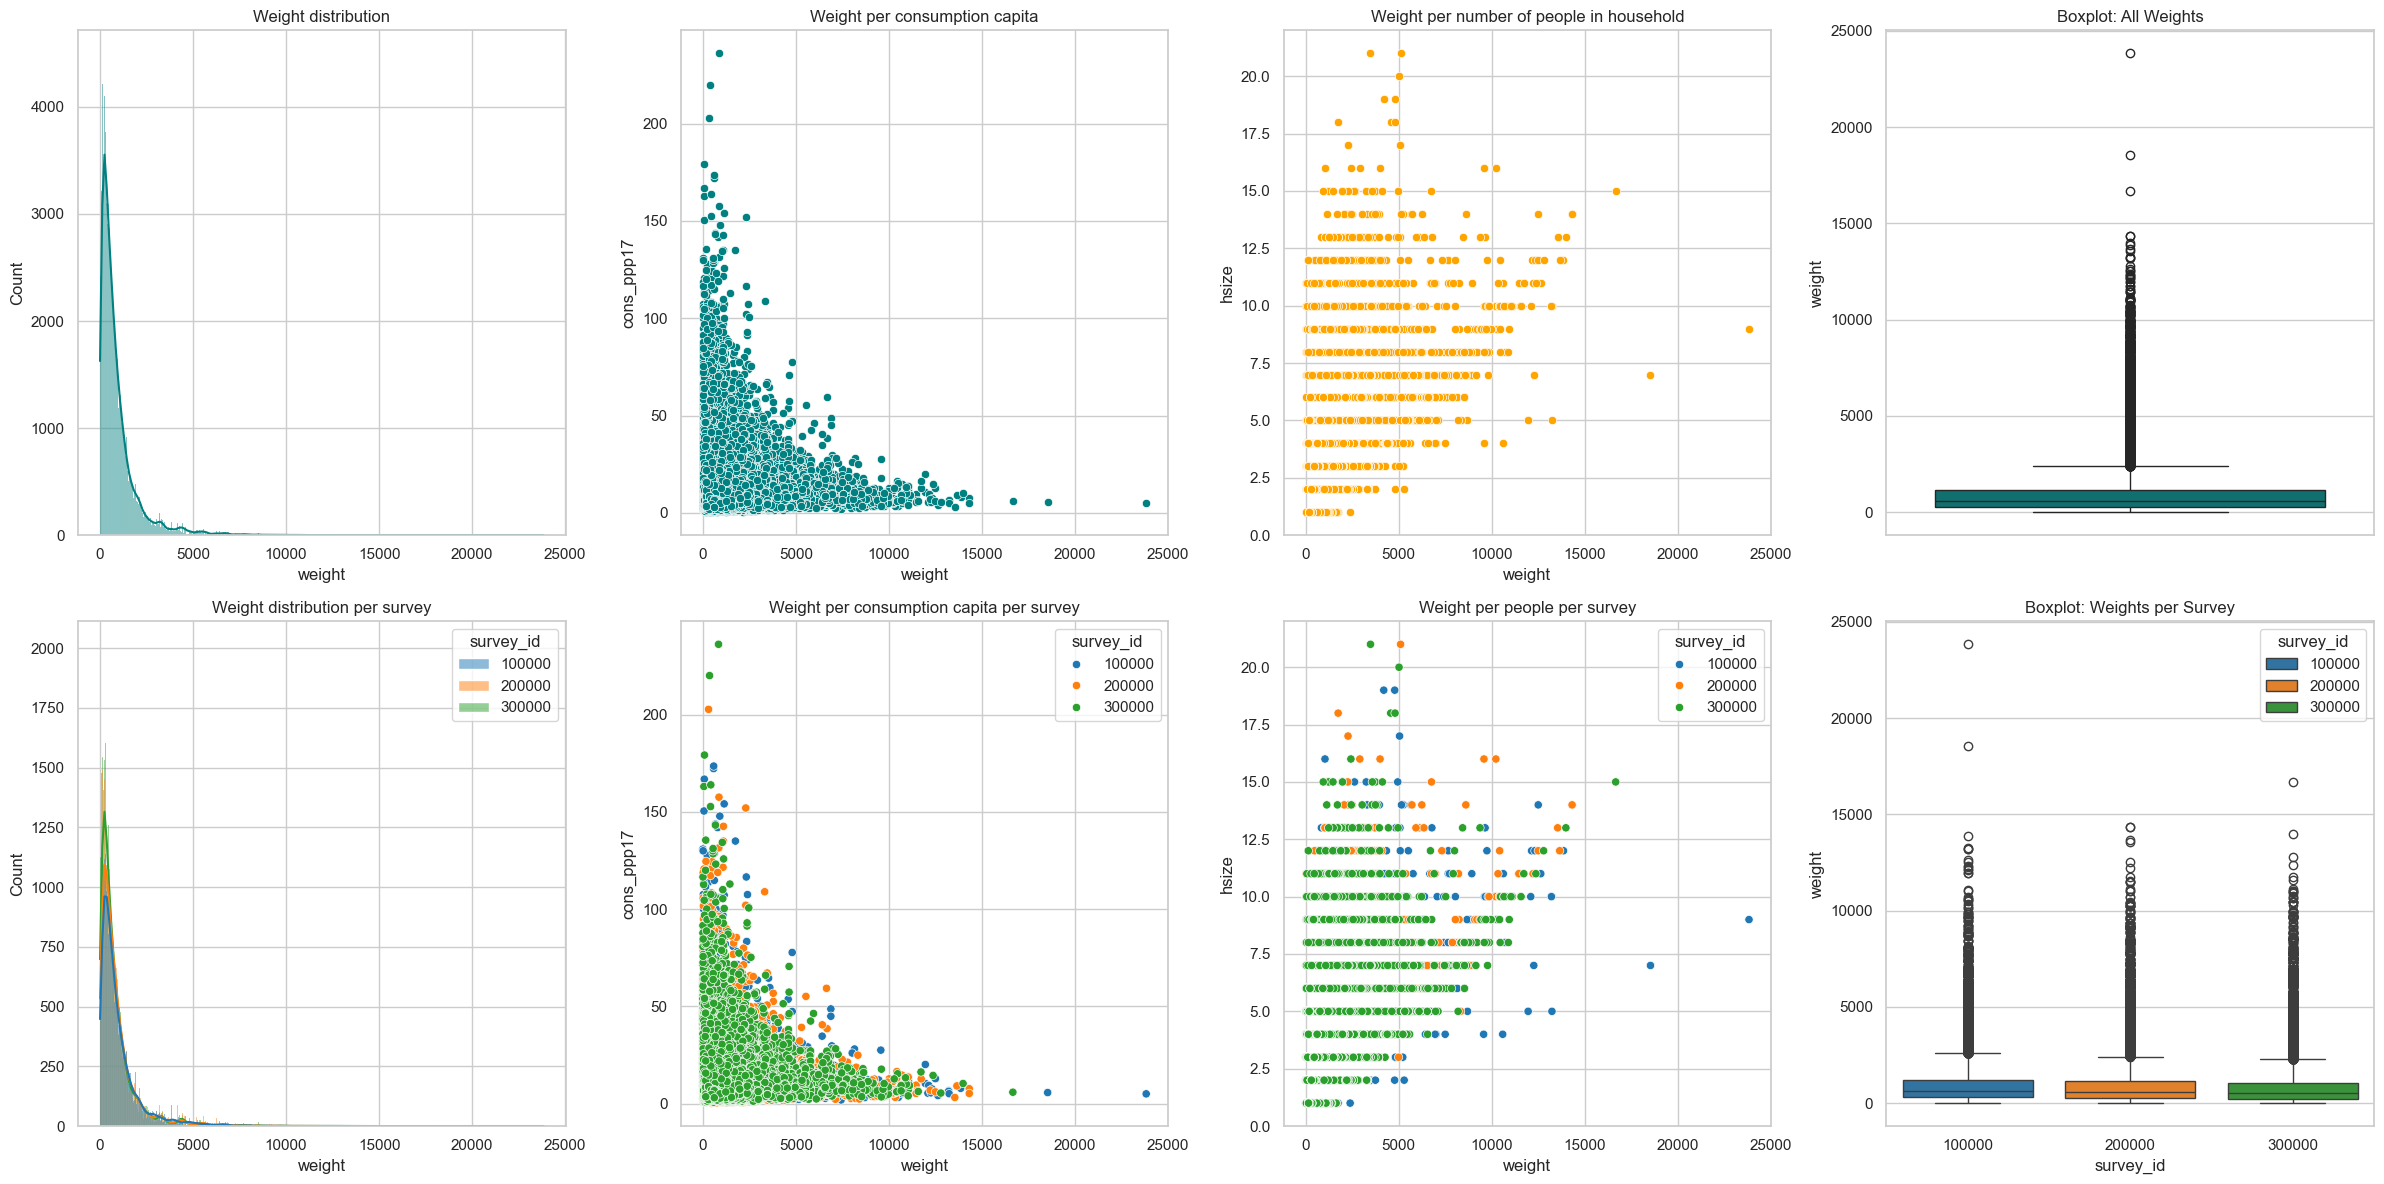

In [9]:
# Set style
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 4, figsize=(24, 12))

# Target distribution
sns.histplot(train_final["weight"], kde=True, color="teal", ax=axes[0][0])
axes[0][0].set_title("Weight distribution")

sns.scatterplot(
    data=train_final,
    x="weight",
    y="cons_ppp17",
    color="teal",
    ax=axes[0][1],
)
axes[0][1].set_title("Weight per consumption capita")

sns.scatterplot(
    x=train_final["weight"],
    y=train_final["hsize"],
    color="orange",
    ax=axes[0][2],
)
axes[0][2].set_title("Weight per number of people in household")

# Boxplot of all weights
sns.boxplot(y=train_final["weight"], ax=axes[0][3], color="teal")
axes[0][3].set_title("Boxplot: All Weights")

# Target distribution per survey
sns.histplot(
    data=train_final,
    x="weight",
    kde=True,
    color="teal",
    ax=axes[1][0],
    hue="survey_id",
    palette="tab10",
)
axes[1][0].set_title("Weight distribution per survey")

sns.scatterplot(
    data=train_final,
    x="weight",
    y="cons_ppp17",
    color="teal",
    ax=axes[1][1],
    hue="survey_id",
    palette="tab10",
)
axes[1][1].set_title("Weight per consumption capita per survey")

sns.scatterplot(
    data=train_final,
    x="weight",
    y="hsize",
    color="orange",
    ax=axes[1][2],
    hue="survey_id",
    palette="tab10",
)
axes[1][2].set_title("Weight per people per survey")

# Boxplot of weights per survey_id
sns.boxplot(
    x="survey_id",
    y="weight",
    data=train_final,
    ax=axes[1][3],
    palette="tab10",
    hue="survey_id",
)
axes[1][3].set_title("Boxplot: Weights per Survey")

plt.tight_layout()
plt.show()

### Target Variable - Per Capita daily expenditure
Plot the target variable, check differences between surveys and observe the logarithmic transformation.

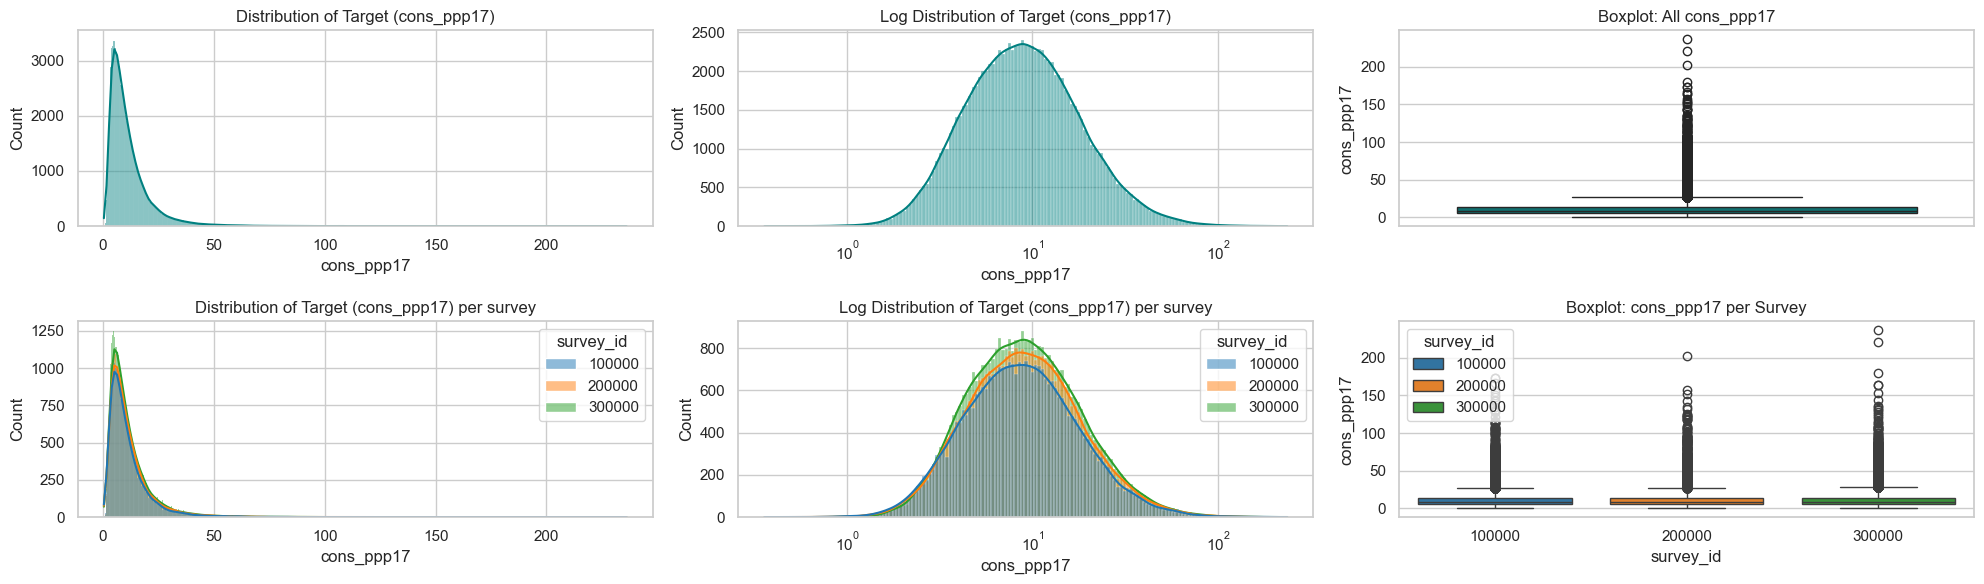

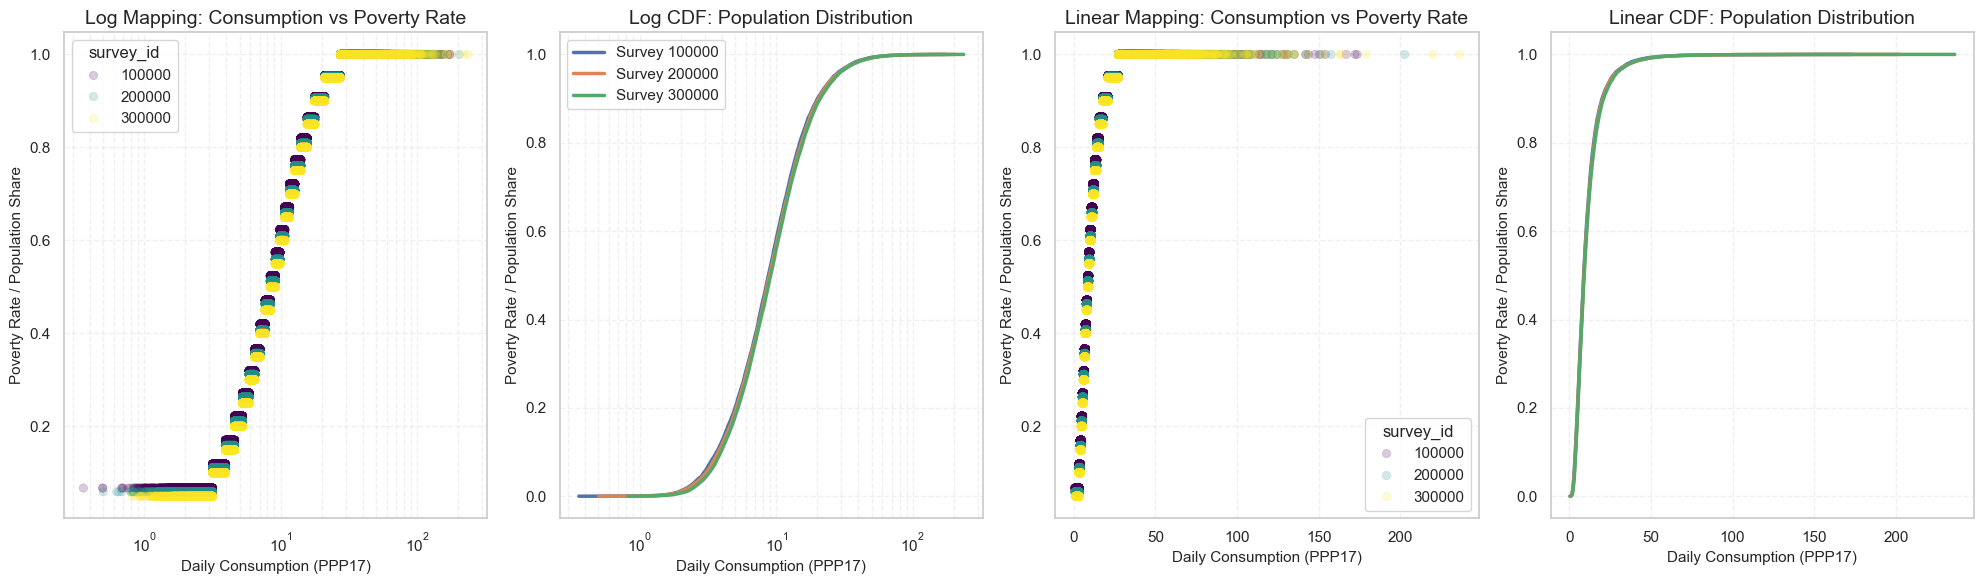

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(20, 6))
# Target distribution
sns.histplot(
    train_final["cons_ppp17"],
    kde=True,
    ax=axes[0][0],
    log_scale=False,
    color="teal",
)
axes[0][0].set_title("Distribution of Target (cons_ppp17)")

# Target distribution (Log scale)
sns.histplot(
    train_final["cons_ppp17"],
    kde=True,
    ax=axes[0][1],
    log_scale=True,
    color="teal",
)
axes[0][1].set_title("Log Distribution of Target (cons_ppp17)")

# Boxplot of all cons_ppp17
sns.boxplot(y=train_final["cons_ppp17"], ax=axes[0][2], color="teal")
axes[0][2].set_title("Boxplot: All cons_ppp17")

# Target distribution per survey
sns.histplot(
    data=train_final,
    x="cons_ppp17",
    hue="survey_id",
    kde=True,
    ax=axes[1][0],
    log_scale=False,
    palette="tab10",
)
axes[1][0].set_title("Distribution of Target (cons_ppp17) per survey")

# Target distribution (Log scale) per survey
sns.histplot(
    data=train_final,
    x="cons_ppp17",
    hue="survey_id",
    kde=True,
    ax=axes[1][1],
    log_scale=True,
    palette="tab10",
)
axes[1][1].set_title("Log Distribution of Target (cons_ppp17) per survey")

# Boxplot of cons_ppp17 per survey_id
sns.boxplot(
    x="survey_id",
    y="cons_ppp17",
    data=train_final,
    ax=axes[1][2],
    palette="tab10",
    hue="survey_id",
)
axes[1][2].set_title("Boxplot: cons_ppp17 per Survey")

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 4, figsize=(20, 6))
sns.scatterplot(
    data=train_final,
    x="cons_ppp17",
    y="poverty",
    hue="survey_id",
    palette="viridis",
    alpha=0.2,
    ax=axes[0],
    edgecolor=None,
)
axes[0].set_title("Log Mapping: Consumption vs Poverty Rate", fontsize=14)
axes[0].set_xscale("log")

for sid in train_final["survey_id"].unique():
    subset = train_final[train_final["survey_id"] == sid].sort_values("cons_ppp17")
    cum_weight_norm = subset["weight"].cumsum() / subset["weight"].sum()
    axes[1].plot(
        subset["cons_ppp17"], cum_weight_norm, label=f"Survey {sid}", linewidth=2.5
    )

axes[1].set_title("Log CDF: Population Distribution", fontsize=14)
axes[1].set_xscale("log")
axes[1].legend()

sns.scatterplot(
    data=train_final,
    x="cons_ppp17",
    y="poverty",
    hue="survey_id",
    palette="viridis",
    alpha=0.2,
    ax=axes[2],
    edgecolor=None,
)
axes[2].set_title("Linear Mapping: Consumption vs Poverty Rate", fontsize=14)

for sid in train_final["survey_id"].unique():
    subset = train_final[train_final["survey_id"] == sid].sort_values("cons_ppp17")
    cum_weight_norm = subset["weight"].cumsum() / subset["weight"].sum()
    axes[3].plot(subset["cons_ppp17"], cum_weight_norm, linewidth=2.5)

axes[3].set_title("Linear CDF: Population Distribution", fontsize=14)

for ax in axes.flat:
    ax.set_xlabel("Daily Consumption (PPP17)", fontsize=11)
    ax.set_ylabel("Poverty Rate / Population Share", fontsize=11)
    ax.grid(True, which="both", ls="--", alpha=0.3)

plt.tight_layout()
plt.show()

### Education and Urban/Rural

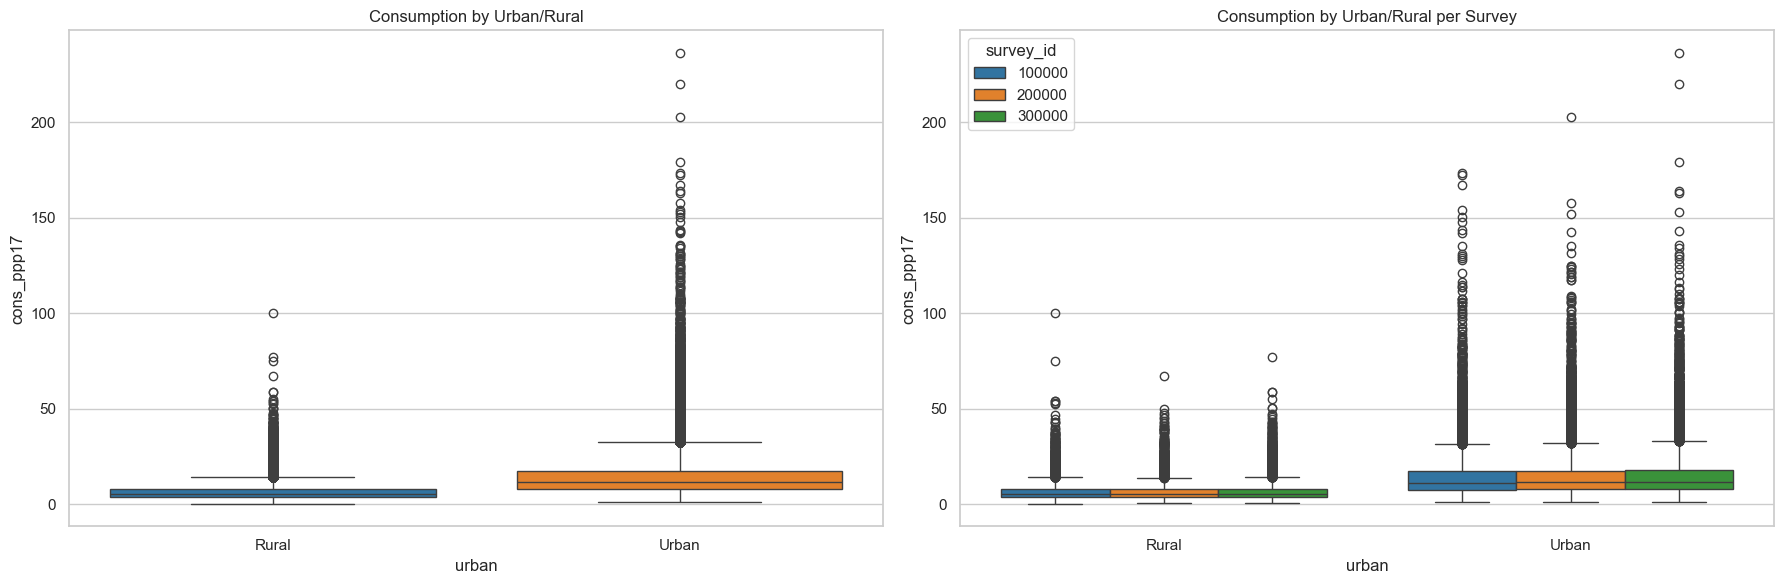

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Consumption by Urban/Rural
sns.boxplot(
    data=train_final,
    x="urban",
    y="cons_ppp17",
    ax=axes[0],
    hue="urban",
    palette="tab10",
    legend=False,
)
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(["Rural", "Urban"])
axes[0].set_title("Consumption by Urban/Rural")

# Consumption by Urban/Rural per Survey
sns.boxplot(
    data=train_final,
    x="urban",
    y="cons_ppp17",
    hue="survey_id",
    palette="tab10",
    ax=axes[1],
)
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(["Rural", "Urban"])
axes[1].set_title("Consumption by Urban/Rural per Survey")

plt.tight_layout()
plt.show()

### Consumption per Education Levels

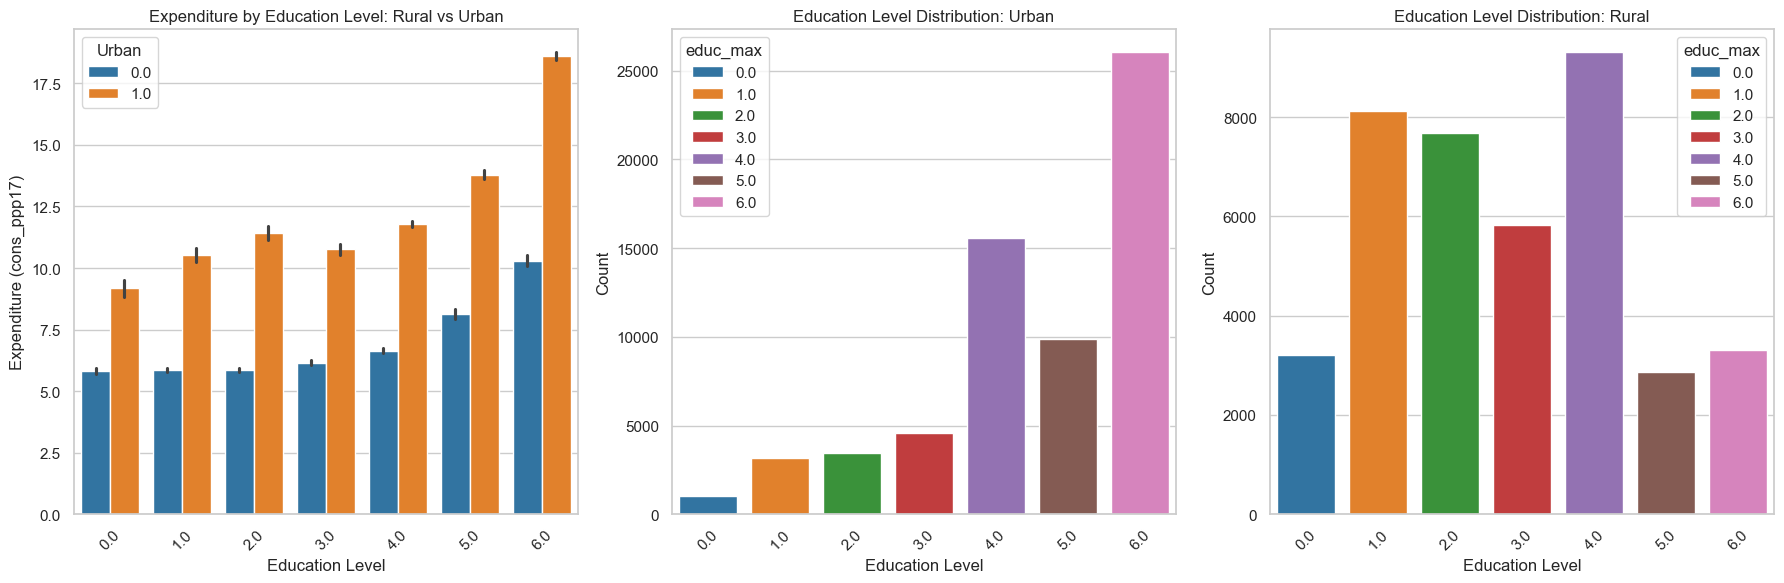

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(
    x="educ_max",
    y="cons_ppp17",
    hue="urban",
    data=train_final,
    ax=axes[0],
    palette="tab10",
)
axes[0].set_title("Expenditure by Education Level: Rural vs Urban")
axes[0].set_xlabel("Education Level")
axes[0].set_ylabel("Expenditure (cons_ppp17)")
axes[0].legend(title="Urban")
axes[0].tick_params(axis="x", rotation=45)

sns.countplot(
    x="educ_max",
    hue="educ_max",
    data=train_final[train_final["urban"] == 1],
    ax=axes[1],
    palette="tab10",
)
axes[1].set_title("Education Level Distribution: Urban")
axes[1].set_xlabel("Education Level")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis="x", rotation=45)


sns.countplot(
    x="educ_max",
    hue="educ_max",
    data=train_final[train_final["urban"] == 0],
    ax=axes[2],
    palette="tab10",
)
axes[2].set_title("Education Level Distribution: Rural")
axes[2].set_xlabel("Education Level")
axes[2].set_ylabel("Count")
axes[2].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

### Consumption per Region

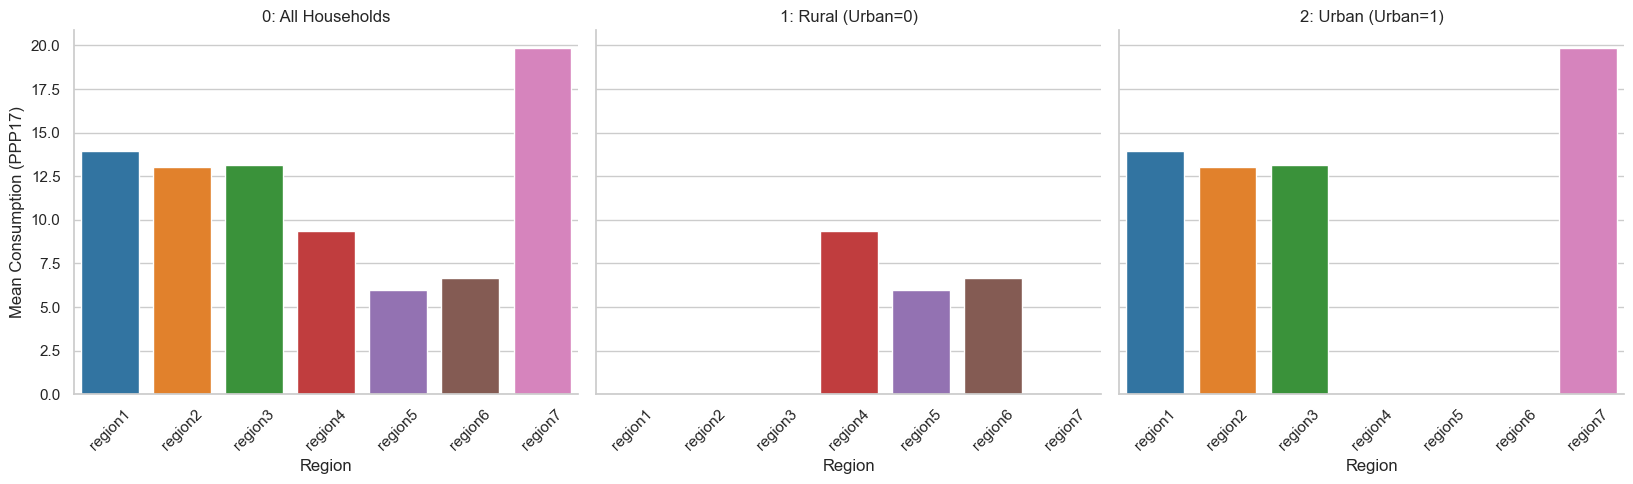

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 1. Melt the regions into a single column for easier plotting
region_cols = [f"region{i}" for i in range(1, 8)]
df_melted = train_final.melt(
    id_vars=["cons_ppp17", "urban"], value_vars=region_cols, var_name="Region"
)
# Filter for actual region membership (where value is 1)
df_melted = df_melted[df_melted["value"] == 1].drop(columns="value")

# 2. Create the three subsets (All, Urban=0, Urban=1)
df_all = df_melted.copy()
df_all["subset"] = "0: All Households"
df_rural = df_melted[df_melted["urban"] == 0].copy()
df_rural["subset"] = "1: Rural (Urban=0)"
df_urban = df_melted[df_melted["urban"] == 1].copy()
df_urban["subset"] = "2: Urban (Urban=1)"

plot_df = pd.concat([df_all, df_rural, df_urban])

# 3. Create the 3-column subplot
g = sns.catplot(
    data=plot_df,
    x="Region",
    y="cons_ppp17",
    col="subset",
    kind="bar",
    palette="tab10",
    height=5,
    aspect=1.1,
    col_order=["0: All Households", "1: Rural (Urban=0)", "2: Urban (Urban=1)"],
    errorbar=None,
    hue="Region",
    legend=False,
)

# Formatting
g.set_titles("{col_name}")
g.set_axis_labels("Region", "Mean Consumption (PPP17)")
for ax in g.axes.flat:
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.savefig("regional_urban_consumption.png")

### Infrastructure (water, electricity, toilet, sewer)

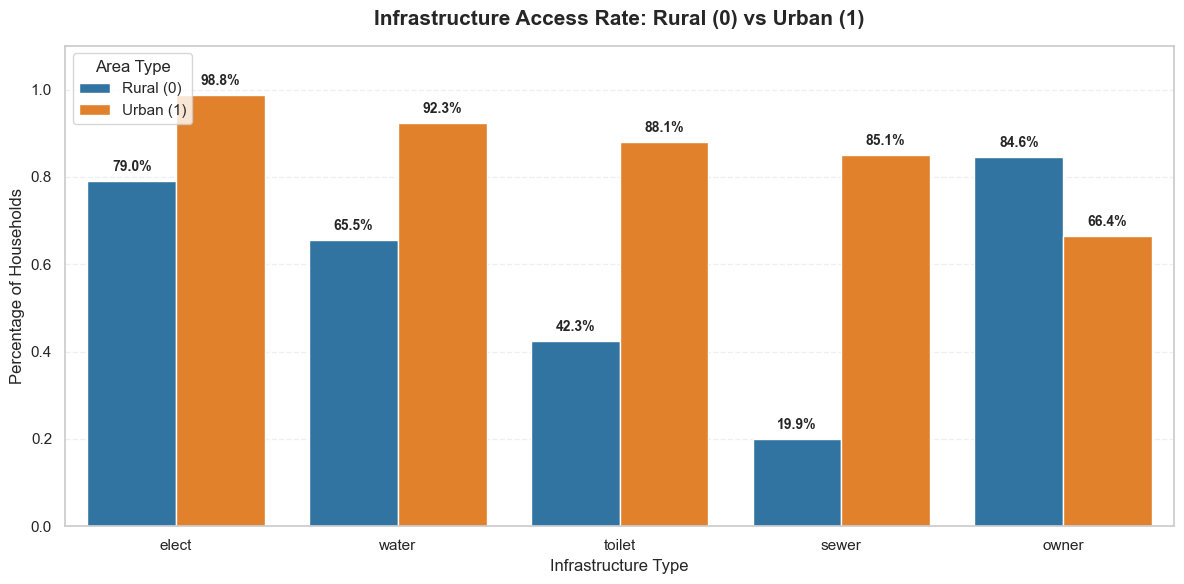

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

infra_cols = ["elect", "water", "toilet", "sewer", "owner"]

melted_infra = train_final.melt(
    id_vars="urban",
    value_vars=infra_cols,
    var_name="Infrastructure",
    value_name="Access_Rate",
)

plt.figure(figsize=(12, 6))

ax = sns.barplot(
    data=melted_infra,
    x="Infrastructure",
    y="Access_Rate",
    hue="urban",
    palette="tab10",
    errorbar=None,
)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f"{height:.1%}",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
            xytext=(0, 5),
            textcoords="offset points",
        )

plt.title(
    "Infrastructure Access Rate: Rural (0) vs Urban (1)",
    fontsize=15,
    fontweight="bold",
    pad=15,
)
plt.ylabel("Percentage of Households", fontsize=12)
plt.xlabel("Infrastructure Type", fontsize=12)
plt.ylim(0, 1.1)
plt.legend(title="Area Type", labels=["Rural (0)", "Urban (1)"], loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()

### Correlations

In [15]:
# Correlations with the target variable
correlations = train_final.corr()["cons_ppp17"].sort_values(ascending=False)
# Top 10 positive and top 10 negative correlations
top_features_idx = pd.concat([correlations.head(11), correlations.tail(10)]).index
print("Top Positive Correlations:\n")
display(correlations.head(10))
print("\nTop Negative Correlations:\n")
display(correlations.tail(10))

Top Positive Correlations:



cons_ppp17                                1.000000
poverty                                   0.774071
utl_exp_ppp17                             0.445688
urban                                     0.392214
educ_max                                  0.377535
sfworkershh                               0.369105
sewer                                     0.368783
sanitation_source_A piped sewer system    0.368783
dweltyp_Separate apartment                0.321562
amenities_index                           0.309289
Name: cons_ppp17, dtype: float64


Top Negative Correlations:



sanitation_source_A septic tank                    -0.170826
sanitation_source_No facilities or bush or field   -0.172284
sworkershh                                         -0.180593
num_children5                                      -0.188043
num_children10                                     -0.203647
num_children18                                     -0.221421
hsize                                              -0.272983
region5                                            -0.309422
sector1d_Agriculture, hunting and forestry         -0.378325
strata                                             -0.446016
Name: cons_ppp17, dtype: float64

### Plots for top correlated features

C:\Users\zikopis\AppData\Local\Temp\ipykernel_11552\3627372306.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=valid_data, x=col, y="cons_ppp17", ax=axes[i], palette="Set2")
C:\Users\zikopis\AppData\Local\Temp\ipykernel_11552\3627372306.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=valid_data, x=col, y="cons_ppp17", ax=axes[i], palette="Set2")
C:\Users\zikopis\AppData\Local\Temp\ipykernel_11552\3627372306.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=valid_data, x=col, y="cons_ppp17", ax=axes[i], palette="Se

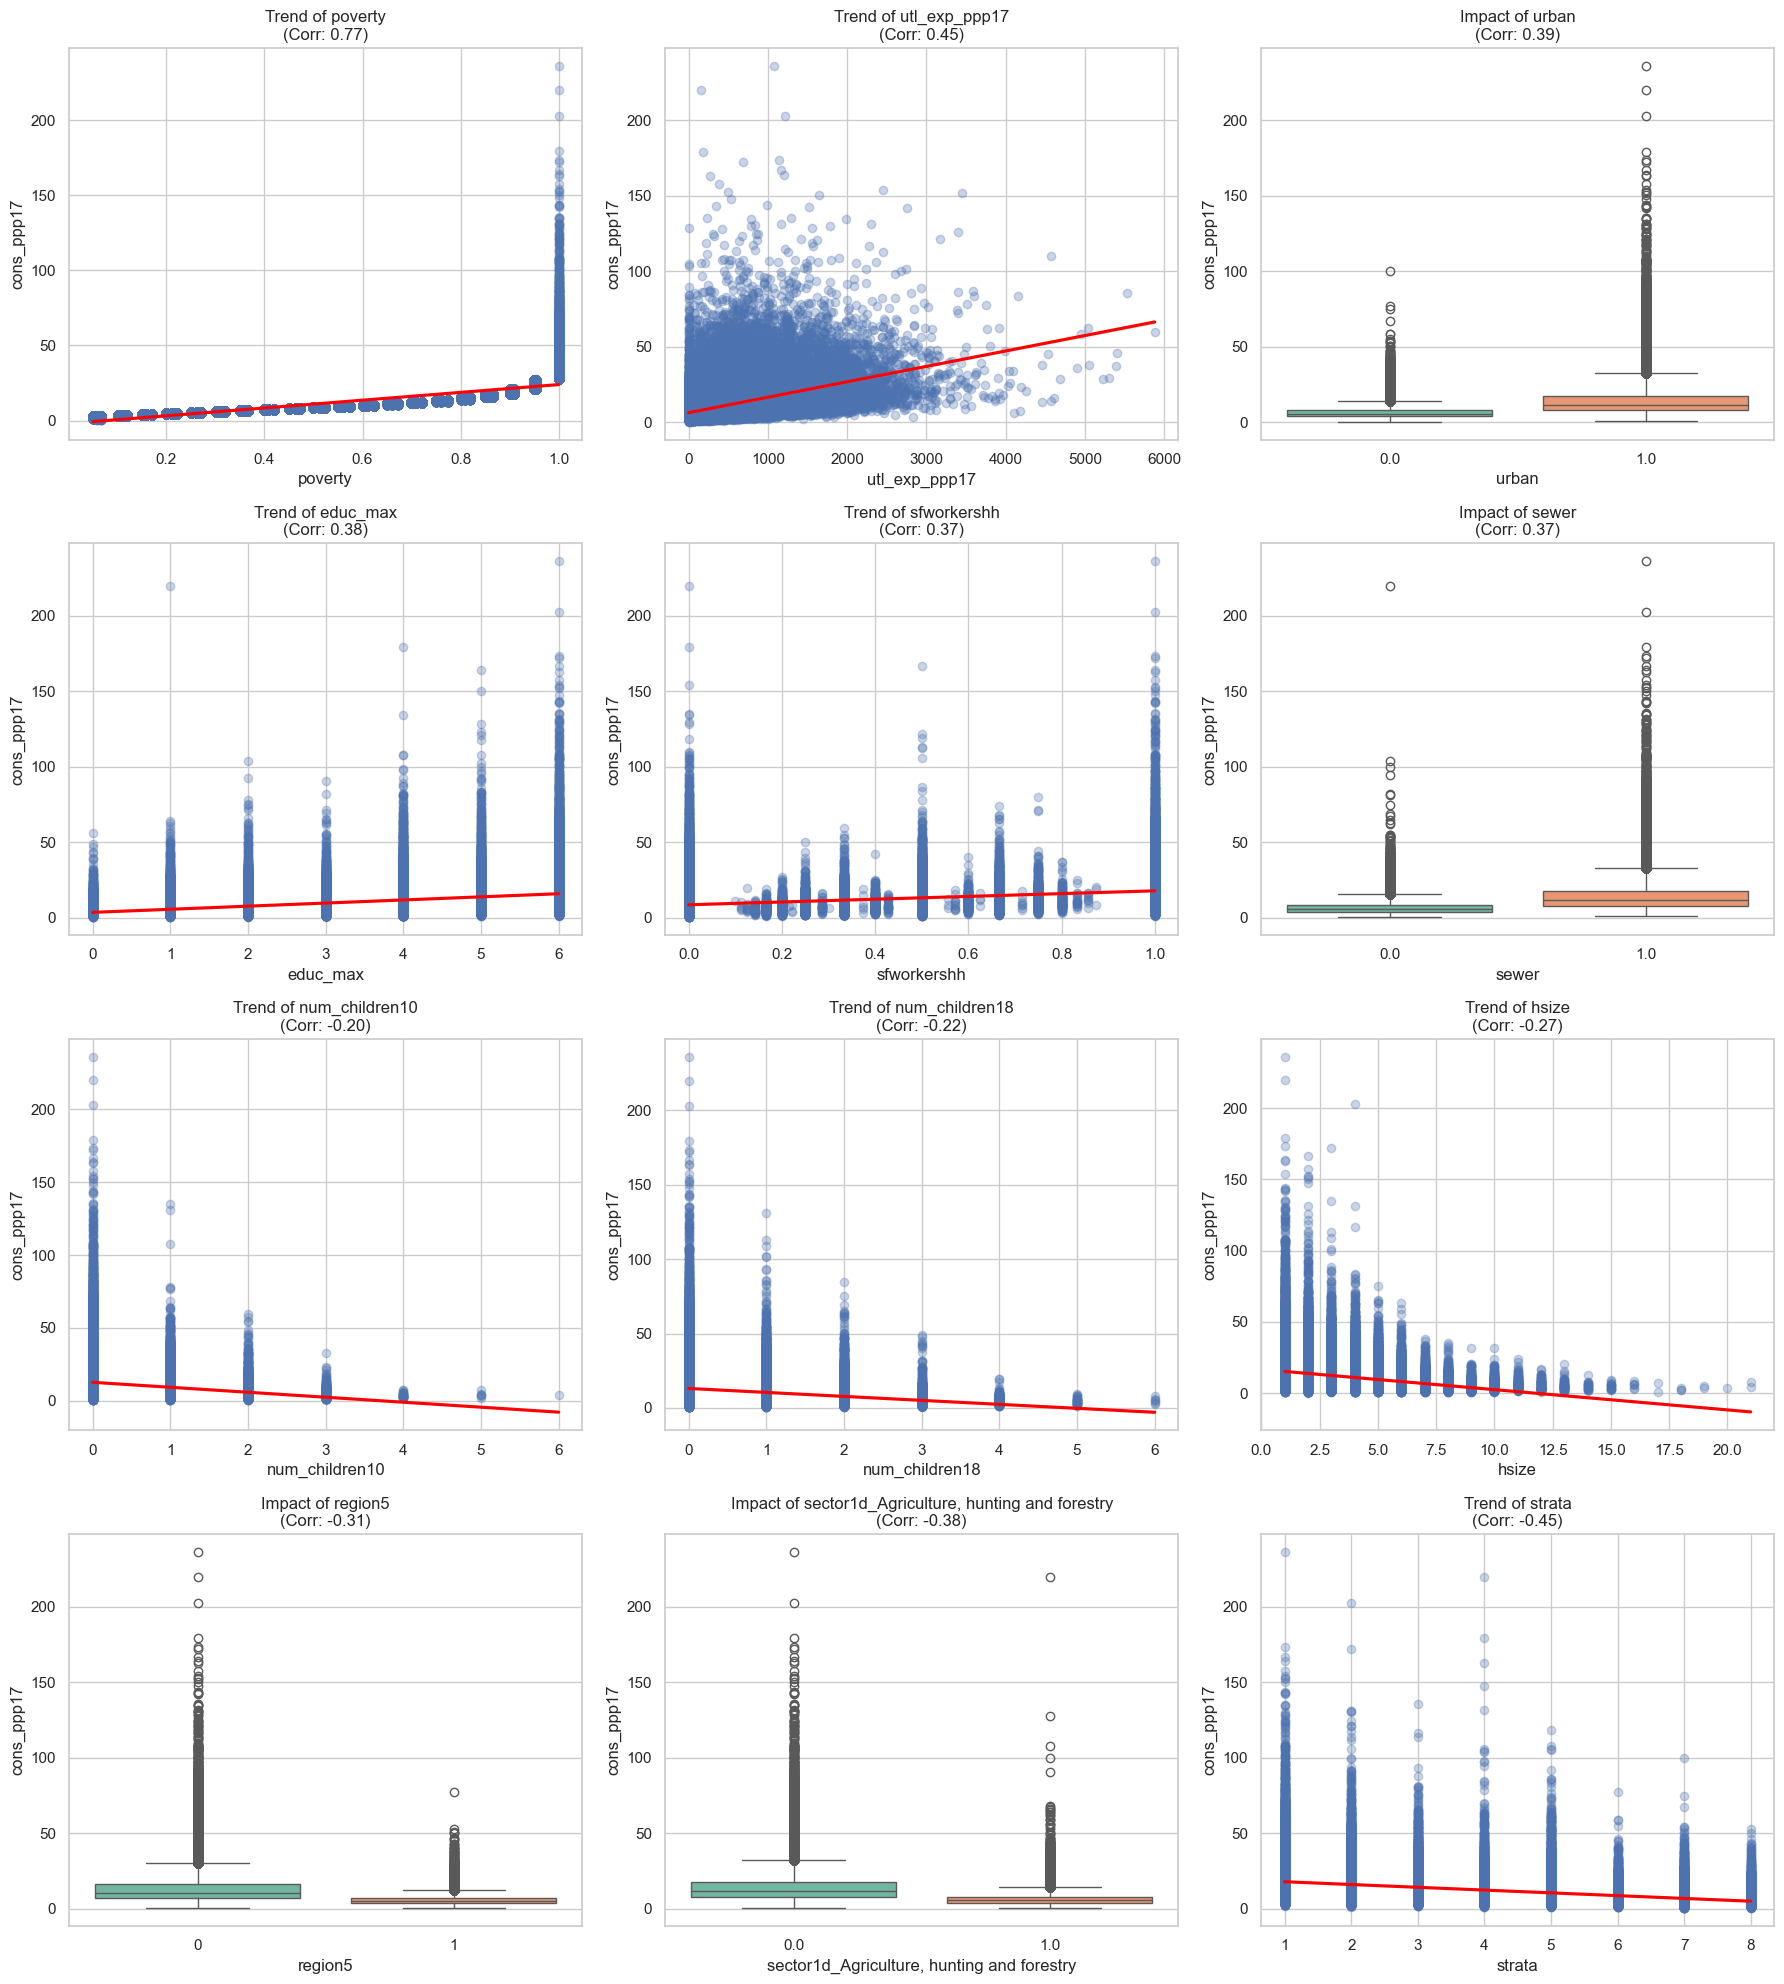

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

top_pos = correlations.iloc[1:7].index.tolist()
top_neg = correlations.tail(6).index.tolist()
plot_features = top_pos + top_neg

fig, axes = plt.subplots(4, 3, figsize=(18, 20))
axes = axes.flatten()

for i, col in enumerate(plot_features):
    temp_series = pd.to_numeric(train_final[col], errors="coerce")
    target_series = train_final["cons_ppp17"]

    # Combine and drop rows where either is NaN
    valid_data = pd.concat([temp_series, target_series], axis=1).dropna()

    if valid_data[col].nunique() <= 2:
        # Categorical Plot
        sns.boxplot(data=valid_data, x=col, y="cons_ppp17", ax=axes[i], palette="Set2")
        axes[i].set_title(f"Impact of {col}\n(Corr: {correlations[col]:.2f})")
    else:
        # Continuous Plot
        sns.regplot(
            data=valid_data,
            x=col,
            y="cons_ppp17",
            ax=axes[i],
            scatter_kws={"alpha": 0.3},
            line_kws={"color": "red"},
        )
        axes[i].set_title(f"Trend of {col}\n(Corr: {correlations[col]:.2f})")

plt.tight_layout()
plt.show()

### Correlation Matrix

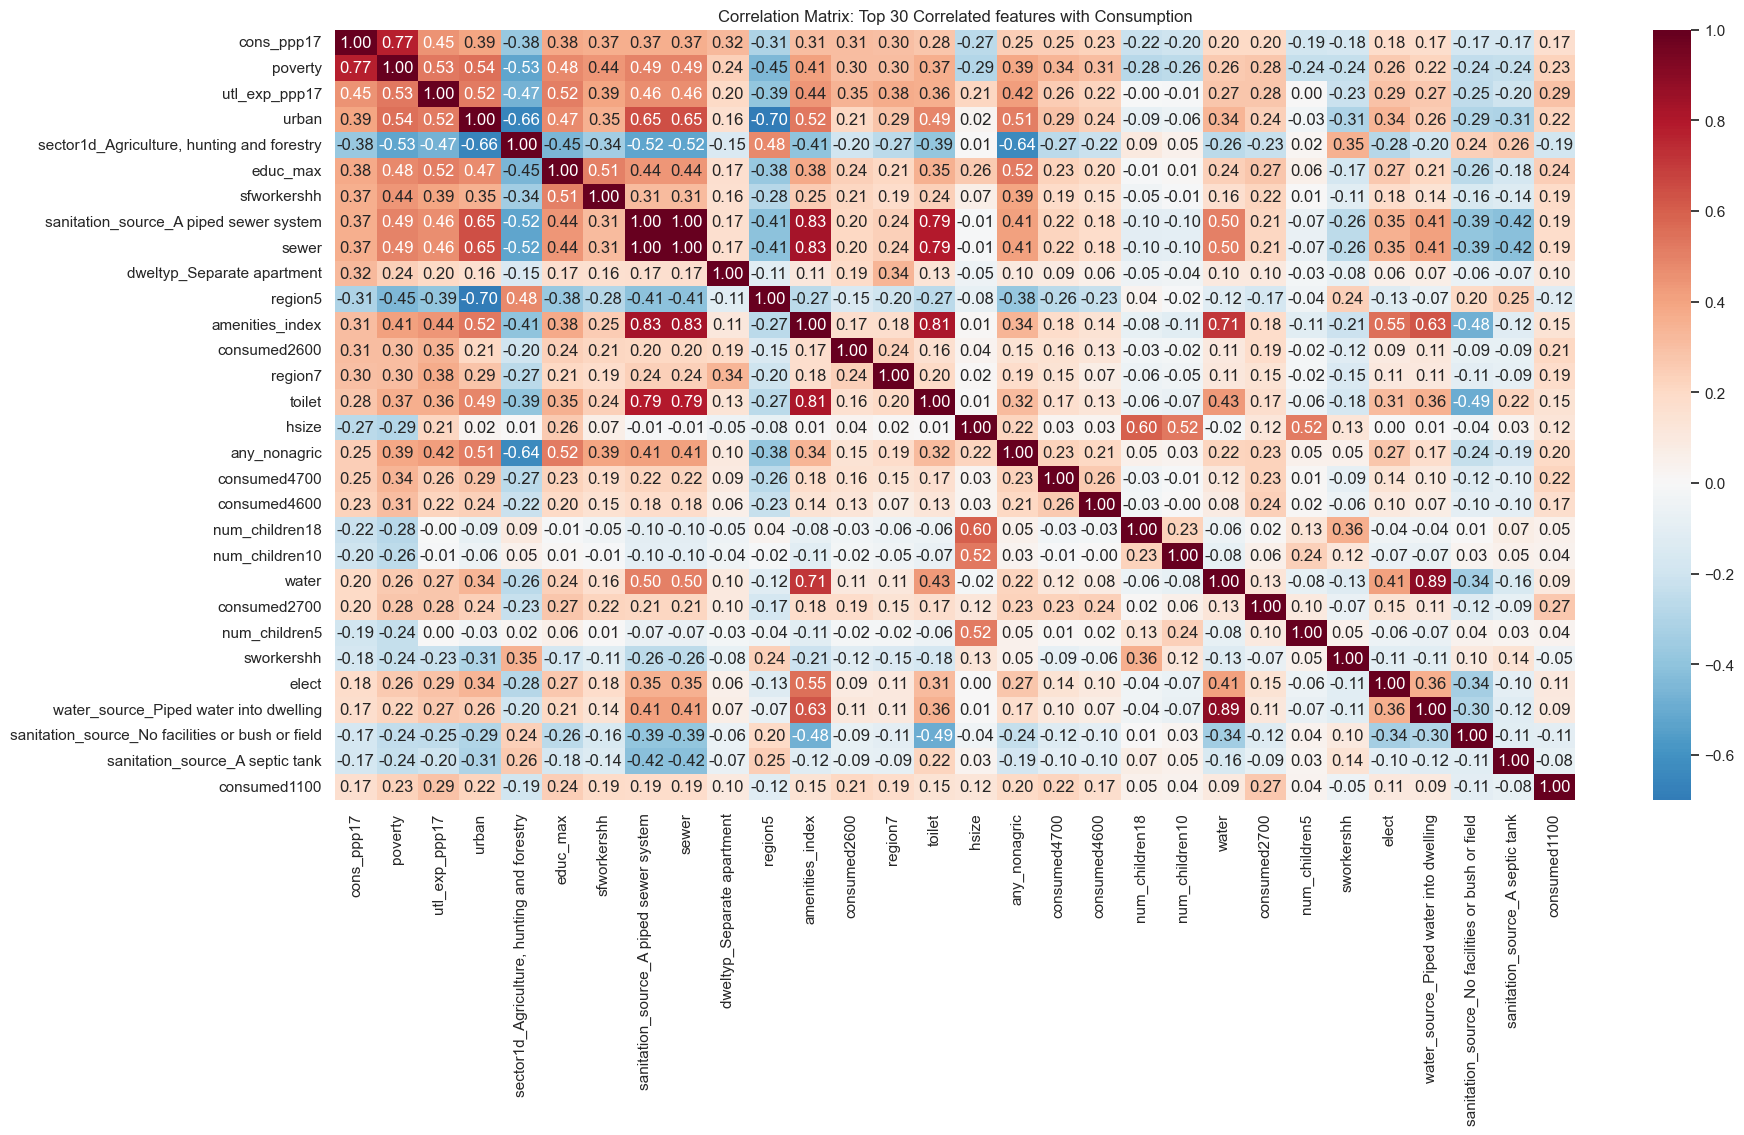

In [17]:
# Exclude columns
exclude_cols = ["hhid", "weight", "strata"]
pline_cols = [col for col in train_final.columns if col.startswith("_pline")]

# Select only numeric columns and drop exclusions
corr_df = train_final.drop(columns=exclude_cols + pline_cols)
corr_df = corr_df.select_dtypes(include=["number"])

# Top-30 dorrelations with target
top_corr_features = (
    corr_df.corr()["cons_ppp17"].abs().sort_values(ascending=False).head(30).index
)
final_corr_matrix = corr_df[top_corr_features].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(final_corr_matrix, annot=True, cmap="RdBu_r", fmt=".2f", center=0)
plt.title("Correlation Matrix: Top 30 Correlated features with Consumption")
plt.show()

### XGBoost
* Use an **XGBoost Regressor**
* Use **reg:absoluteerror** to align with the MAPE metric that is used for evaluation
* Use sample weighting during training based on the given formula to prioritize percentiles close to the 40th percentile
* Use grid search to find optimal parameters

In [18]:
import zipfile

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split

# Prepare train set
X = train_final.drop(
    columns=["cons_ppp17", "survey_id", "hhid", "poverty", "poverty_bins", "strata"],
    errors="ignore",
)
# Use logarithmic scale for target
y_log = np.log1p(train_final["cons_ppp17"])

survey_weights = train_final["weight"]

# Use metric weights in training to add focus around 40th percentile
metric_weights = 1.0 - np.abs(0.4 - train_final["poverty"])

(
    X_train,
    X_val,
    y_train_log,
    y_val_log,
    w_train_metric,
    w_val_metric,
    w_train_survey,
    w_val_survey,
) = train_test_split(
    X, y_log, metric_weights, survey_weights, test_size=0.2, random_state=42
)

# Tuning
xgb_reg = xgb.XGBRegressor(
    objective="reg:absoluteerror",
    random_state=42,
    n_jobs=-1,
    enable_categorical=True,
    tree_method="hist",
)

param_grid = {
    "n_estimators": [500, 1000],
    "max_depth": [6, 8],
    "learning_rate": [0.03, 0.05],
    "subsample": [0.8],
    "colsample_bytree": [0.7],
}

grid_search = GridSearchCV(
    xgb_reg, param_grid, cv=3, scoring="neg_mean_absolute_error", verbose=1, n_jobs=-1
)


grid_search.fit(X_train, y_train_log, sample_weight=w_train_metric)
best_xgb = grid_search.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


### Results

In [ ]:
# Results
X_test_aligned = test_final[X_train.columns]
test_predictions = np.expm1(best_xgb.predict(X_test_aligned))

# Consumption
df_cons_output = test_final[["survey_id", "hhid"]].copy()
df_cons_output["per_capita_household_consumption"] = test_predictions
df_cons_output.columns = [
    "survey_id",
    "household_id",
    "cons_ppp17",
]
df_cons_output.to_csv("predicted_household_consumption.csv", index=False)

# Distribution
results_df = pd.DataFrame(
    {
        "survey_id": test_final["survey_id"],
        "weight": test_final["weight"],
        "pred_cons": test_predictions,
    }
)
thresholds_float = [
        3.17,
        3.94,
        4.60,
        5.26,
        5.88,
        6.47,
        7.06,
        7.70,
        8.40,
        9.13,
        9.87,
        10.70,
        11.62,
        12.69,
        14.03,
        15.64,
        17.76,
        20.99,
        27.37,
    ]
poverty_distribution = []
for s_id in results_df["survey_id"].unique():
    survey_data = results_df[results_df["survey_id"] == s_id]
    total_pop_w = survey_data["weight"].sum()
    row = {"survey_id": s_id}

    # Enforce monotonicity (rates must increase as thresholds increase)
    current_weighted_sum = 0
    sorted_thresholds = sorted(thresholds_float)
    for t in sorted_thresholds:
        weighted_below = survey_data.loc[survey_data["pred_cons"] < t, "weight"].sum()
        row[f"pct_hh_below_{t:.2f}"] = weighted_below / total_pop_w
    poverty_distribution.append(row)

df_poverty_dist = pd.DataFrame(poverty_distribution)
df_poverty_dist.to_csv("predicted_poverty_distribution.csv", index=False)

# Zip for submission
with zipfile.ZipFile("submission.zip", "w") as zipf:
    zipf.write("predicted_household_consumption.csv")
    zipf.write("predicted_poverty_distribution.csv")